In [7]:
import json #for json files
import sys #used to close json file
import asf_search as asf #ASF search API tool
from hyp3_sdk import HyP3 #ASF API tool for sending INSAR jobs
import csv #creating a .csv
import requests #for checking status of job

#import libraries for file management
import os 
from zipfile import ZipFile 
import shutil

import geopandas as gpd
import pandas as pd
from datetime import datetime
from datetime import timedelta

import psycopg2

In [2]:
conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)

In [7]:
directory = os.getcwd()
inputFiles = os.path.join(directory,"geodata")

shp = gpd.GeoDataFrame.from_file('geodata/SC-Unit1D.shp')
geometry = str(shp['geometry'][0])
date = str(shp['Date'][0])
JobName = str(shp['Name'][0]).replace(" ","").replace("-","")
print(JobName)
d2 = datetime.strptime(date, '%Y-%m-%d')
end = str(d2 + timedelta(days = 1)*365)
start = str(d2 - timedelta(days = 1)*365)


Unit1D2019


In [3]:
CRS = str(shp.crs)
print(CRS)
type(CRS)

epsg:4326


str

In [ ]:
jsonFile = open('geodata/Login.json')
login = json.load(jsonFile)

userName = login['UserName']
if userName == "":
    print("Please input Username")
    sys.exit()
pw = login['Password']
if pw =="":
    print("Please input Password")
    sys.exit()

jsonFile.close()

In [ ]:
#Create an API search based on set parameters
searchResults = asf.search(
    #search parameters taken from filled out json file
    platform = "Sentinel-1",
    beamMode = "IW",
    polarization = "VV+VH",
    intersectsWith = geometry, 
    processingLevel= "SLC",
    start = start,
    end = end
)
print('Done')
data = searchResults.geojson()

In [5]:
#Extracts scenes from job search and creates list of all scene names
def get_scene_name(): 
    count = len(data["features"])                   
    scenes = []
    dates = []
    for x in range(count):
        scene = data["features"][x]["properties"]["sceneName"]
        date = data["features"][x]["properties"]["startTime"]
        scenes.append(scene)
        dates.append(date)
    scenes.reverse()
    dates.reverse()
    df = pd.DataFrame(list(zip(dates, scenes)),columns =['Dates', 'SceneNames'])
    return df
scenesList= get_scene_name() #list with all scene names

In [ ]:

filtered = scenesList.drop_duplicates()
scenes = list(filtered['SceneNames'])
dates = list(filtered['Dates'])

In [ ]:
def create_jobs(data,date): 
    jobs = [] 
    count = len(data) 
    for i in range(count-1): 
        scene1 = data[i]
        scene2 = data[i+1]
        if date[i+1].endswith('Z'):
            sceneDate = datetime.strptime(date[i+1], '%Y-%m-%dT%H:%M:%S.%fZ').date()
        else:
            sceneDate = datetime.strptime(date[i+1], '%Y-%m-%dT%H:%M:%S.%f').date()
        insar_job = HyP3.prepare_insar_job(scene1, scene2, name = JobName, include_displacement_maps=True,include_dem=True,include_look_vectors=True)
        jobs.append(insar_job) 
        pair = scene1+','+scene2
        try:
            cursor = conn.cursor()
            cursor.execute("INSERT INTO project1 (pair, site, reference_date) VALUES(%s, %s, %s)", (pair, JobName, sceneDate))
            conn.commit()
            cursor.close()
        except:
            conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)
    return jobs 
jobsList = create_jobs(scenes, dates)


In [ ]:
hyp3 = HyP3(username = userName, password = pw) #authenticate using ASF credentials
batch = hyp3.submit_prepared_jobs(prepared_jobs = jobsList)

#Creates New Folder called "data" where the jobs will be downloaded
output = os.path.join(directory, 'rawData')
if not os.path.exists(output):
    os.makedirs(output)

#Watch and Download job
if not batch.complete():
    batch = hyp3.watch(batch)
#Downloads files into data folder
batch.download_files(location = output)

In [ ]:
#Creates List of zip file names
zipfiles = os.listdir(output)

#Unzips each zip file and deletes the zip
for x in range(len(zipfiles)):
    file = os.path.join(output, zipfiles[x])
    with ZipFile(file, 'r') as zip:
        zip.extractall(output)
    os.remove(file)

In [ ]:

output = os.path.join(directory, 'rawData')
folderList = os.listdir(output)
tifList = []
#Loop through the folders
for x in range(len(folderList)):
    folderName = os.path.join(output, folderList[x])
    fileList = os.listdir(folderName)
    #Loop through files in folder
    for file in fileList:
        #Select file that ends in vert_disp.tif
        if file.endswith(".tif"):
            fileName = os.path.join(folderName, file)
            tifList.append(fileName)
        if file.startswith(folderList[x]+'.txt'):
            fileName = os.path.join(folderName, file)
            f = open(fileName,'r')
            lines = f.readlines()
            scene1 = lines[0].split(' ')
            scene2 = lines[1].split(' ')
         
            pair = scene1[2].replace('\n','')+','+scene2[2].replace('\n','')
            try:
                cursor = conn.cursor()
                cursor.execute("SELECT insar_name from project1 where insar_name = %s",(folderList[x],))
                row = cursor.fetchall()
                if row == []:
                    cursor.execute("UPDATE project1 SET insar_name = %s where pair = %s",(folderList[x],pair))
                    conn.commit()
                cursor.close()
            except:
                conn = psycopg2.connect(host='localhost',database = 'postgres', user='postgres',password = 'postgrespw',port=32768)

In [8]:
#Libraries for dealing with geotifs
from osgeo import gdal,ogr
import rasterio as rio

In [ ]:
dataset = rio.open(tifList[0])
boundingBox = dataset.bounds
left = boundingBox.left
right = boundingBox.right
top = boundingBox.top
bottom = boundingBox.bottom
print(boundingBox)
for x in range(1,len(tifList)):
    dataset = rio.open(tifList[x])
    boundingBox = dataset.bounds
    if boundingBox.left < left:
        left = boundingBox.left
    if boundingBox.right < right:
        right = boundingBox.right
    if boundingBox.top < top:
        top = boundingBox.top
    if boundingBox.bottom < bottom:
        bottom = boundingBox.bottom
    print(left,bottom,right,top)
minbbox = (left,bottom,right,top)

In [ ]:
#Crop the water mask incase it does not have the min bounds
#For loop to crop all the tif files to the min bounds
#all files need to be the same height and width to work with them in numpy
opts = gdal.WarpOptions(options=['tr'], outputBounds=minbbox, format="GTiff")
for geoTif in tifList:
    dataset = gdal.Open(geoTif)
    newfile = gdal.Warp(geoTif.split('.')[0]+'_crop.tif', dataset , options=opts)
    dataset = None #close the file

In [ ]:
import subprocess
from mintpy.cli import tsview
from mintpy.cli import plot_transection
import ipympl

In [ ]:
runMinty = subprocess.run(["smallbaselineApp.py","mintpyConfigFile.txt"])
getVelocity = subprocess.run(["smallbaselineApp.py", "--dostep", "velocity", "mintpyConfigFile.txt"])

In [ ]:
%matplotlib widget
ts_file = os.path.expanduser('timeseries.h5')
cmd = f'{ts_file} --yx 220 300 --figsize 9 3'
tsview.main(cmd.split())

In [ ]:
vel_file = os.path.expanduser('avgPhaseVelocity.h5')
cmd = f'{vel_file} --figsize 10 5'
plot_transection.main(cmd.split())

In [9]:
import h5py
import pandas as pd

In [10]:
directory =os.getcwd()
timeseriesPath = os.path.join(directory, 'new')
geometryPath = os.path.join(timeseriesPath, 'inputs')
geometryFile = os.path.join(geometryPath, ' geometryGeo.h5')
timeseriesh5 = os.path.join(timeseriesPath, 'timeseries.h5')

In [11]:
with h5py.File(timeseriesh5,'r') as f:
    keys=list(f['/'].attrs.keys())
    values = list(f['/'].attrs.values())
    h5df=pd.DataFrame(list(zip(keys, values)), columns =['keys','values'])

    print(h5df)

                                       keys       values
0                                    ALOOKS            4
1                              ANTENNA_SIDE           -1
2                        AZIMUTH_PIXEL_SIZE         56.4
3                                     BANDS            1
4                           CENTER_LINE_UTC  1111.334526
..                                      ...          ...
61  mintpy.networkInversion.minNormVelocity         True
62    mintpy.networkInversion.minRedundancy          1.0
63        mintpy.networkInversion.numIfgram           47
64   mintpy.networkInversion.obsDatasetName  unwrapPhase
65       mintpy.networkInversion.weightFunc          var

[66 rows x 2 columns]


In [43]:
lats = h5df[h5df['keys'].str.contains('LAT_REF')].drop_duplicates(['values'])
longs = h5df[h5df['keys'].str.contains('LON_REF')].drop_duplicates(['values'])
EPSG = h5df[h5df['keys'].str.contains('EPSG')]
setEPSG = str('EPSG:'+list(EPSG['values'])[0])
lat1 = list(lats['values'])[0]
lat2 = list(lats['values'])[1]
long1 = list(longs['values'])[0]
long2 = list(longs['values'])[1]
print(long1,lat1,long2,lat2)
print(setEPSG)

259840.0 3122000.0 544560.0 3349440.0
EPSG:32615


In [ ]:
subprocess.run(['gdal_translate', '-of', 'GTiff', '-a_srs', setEPSG, '-a_ullr',long1,lat1,long2,lat2, './new/timeseries.h5', './new/timeseries3.tif'])
#Long1 lat1 long2 lat2 
#!gdal_translate -of GTiff -a_srs EPSG:32615 -a_ullr 259840 3122000 544560 3349440 ./new/timeseries.h5 ./new/timeseries3.tif

In [8]:
import rioxarray
import rasterio
from rasterio.warp import calculate_default_transform, reproject, Resampling

In [10]:
from rasterio.plot import plotting_extent

In [ ]:
# Create a buffered polygon layer from your plot location points
shpBuff = shp.copy()

# Buffer each point using a 20 meter circle radius 
# and replace the point geometry with the new buffered geometry
shpBuff["geometry"] = shp.geometry.buffer(0.01)
shpBuff.geometry
inputFiles = os.path.join(directory,"geodata")
saveBuffer = os.path.join(inputFiles,JobName+"buffed.shp")
shpBuff.to_file(saveBuffer)


In [63]:
import rioxarray as rxr
import rasterstats as rs
import numpy as np
import rasterio as rio
import matplotlib.pyplot as plt

In [35]:
timeseries = os.path.join(timeseriesPath, 'timeseries3.tif')
ts = rxr.open_rasterio(timeseries)
tsNoZeros = ts.where(ts != 0, np.nan)

In [39]:
crs = shp.crs
tsFinal = tsNoZeros.rio.reproject(crs)

In [ ]:
# Extract zonal stats
timeseriesStats = gpd.GeoDataFrame(columns=['count','min','mean','max','median'])
for x in range(len(tsFinal.values)):
    current = tsFinal.values[x]
    currentStats = rs.zonal_stats(saveBuffer,
                                    current,
                                    affine=tsFinal.rio.transform(),
                                    geojson_out=True,
                                    copy_properties=True,
                                    stats="count min mean max median")
    properties=currentStats[0]['properties']
    stats = properties['count'], properties['min'], properties['mean'], properties['max'],properties['median']
    
    #print(type(currentStats[0]))
    timeseriesStats.loc[len(timeseriesStats)] = stats

print(timeseriesStats)
# View object type


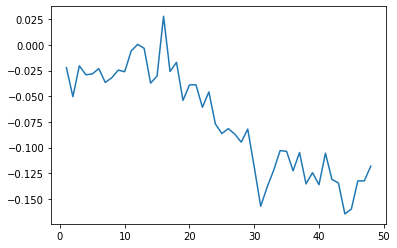

In [65]:
fig = plt.figure()
ax = plt.axes()
ax.plot(timeseriesStats['mean'])